- VGG 구현 및 정리: https://blogofth-lee.tistory.com/264
- VGGNet으로 ImageNet학습하기: https://minjoos.tistory.com/6
- VGGnet(2014) 구현하기: https://deep-learning-study.tistory.com/521
- VGGNet 논문 리뷰와 구현: https://wolfy.tistory.com/240
- VGG16 Transfer Learning - Kaggle: https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch/notebook

In [1]:
# import package
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torchsummary import summary 
from torch import optim 
from torch.optim.lr_scheduler import StepLR 

from torchvision import datasets
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader

from torchvision import utils
import matplotlib.pyplot as plt 
plt.ion()   # 대화형 모드

import numpy as np
import os, time, copy

In [2]:
# specify a data path
path2data = '../../data/STL10'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# check train_ds
img, _ = train_ds[1]
print(img.shape)

print(len(train_ds))
print(len(val_ds))

torch.Size([3, 96, 96])
5000
8000


In [4]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [
  np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds
]
train_stdRGB = [
  np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds
]

train_meanRGB = np.mean(np.array(train_meanRGB), axis=0)
train_stdRGB = np.mean(np.array(train_stdRGB), axis=0)

train_meanR = train_meanRGB[0]
train_meanG = train_meanRGB[1]
train_meanB = train_meanRGB[2]
train_stdR = train_stdRGB[0]
train_stdG = train_stdRGB[1]
train_stdB = train_stdRGB[2]

print(train_meanRGB, train_stdRGB)

[0.44671074 0.43981016 0.4066461 ] [0.224146   0.22148886 0.22389936]


In [5]:
val_meanRGB = [
  np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds
]
val_stdRGB = [
  np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds
]

val_meanRGB = np.mean(np.array(val_meanRGB), axis=0)
val_stdRGB = np.mean(np.array(val_stdRGB), axis=0)

val_meanR = val_meanRGB[0]
val_meanG = val_meanRGB[1]
val_meanB = val_meanRGB[2]
val_stdR = val_stdRGB[0]
val_stdG = val_stdRGB[1]
val_stdB = val_stdRGB[2]

print(val_meanRGB, val_stdRGB)

[0.44723058 0.43964264 0.40495682] [0.22489503 0.22172801 0.22369823]


In [6]:
img, _ = train_ds[1]
print(img.shape)

torch.Size([3, 96, 96])


In [7]:
# define the image transformation
# using normalize, horizontal reflection
transformer = transforms.Compose([
  transforms.Resize(224),
  transforms.ToTensor(),
  transforms.Normalize(
    train_meanRGB, train_stdRGB
  )
])

# apply transformation
train_ds.transform = transformer
val_ds.transform = transformer

In [8]:
img, _ = train_ds[1]
print(img.shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images indices: 2732
img shape: torch.Size([3, 224, 224])


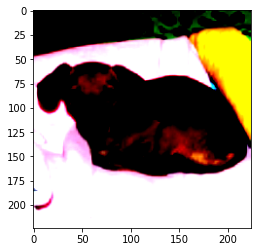

In [9]:
# display transformed sample images
def show(img, y=None, color=True):  
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title(f'labels: {str(y)}')

np.random.seed(0)
torch.manual_seed(0)

# pick a random sample image
rnd_inds = int(np.random.randint(0, len(train_ds), 1))
img, label = train_ds[rnd_inds]
print(f'images indices: {rnd_inds}')
print(f'img shape: {img.shape}')

# plt.figure(figsize=(20, 20))
show(img)

In [10]:
# create dataloader
train_dl = DataLoader(
  train_ds, batch_size=4, shuffle=True
)
val_dl = DataLoader(
  val_ds, batch_size=4, shuffle=True
)

### 모델 구축
> VGGnet은 4가지 종류가 있습니다. 각 종류에 해당하는 정보를 딕셔너리로 만듭니다. 
> - 숫자는 conv layer를 거친 후에 출력값 채널을 의미합니다. 
> - M은 pooling layer를 의미합니다.  

In [11]:
VGG_types = {
  'VGG11': [
    64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'
  ],
  'VGG13': [
    64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512
  ],
  'VGG16': [
    64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'
  ],
  'VGG19': [
    64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'
  ]
}

In [12]:
# define VGGNet class
class VGGnet(nn.Module):
  # define a function to create conv layer taken the key of VGG type dict
  def create_conv_laters(self, architecture):
    layers = []
    in_channels = self.in_channels
    for x in architecture:
      if isinstance(x, int): # int means conv layer
        out_channels = x
        layers += [
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
          nn.BatchNorm2d(x),
          nn.ReLU()
        ]
        in_channels = x
      elif x == 'M':
        layers += [
          nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        ]
    
    return nn.Sequential(*layers)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
  
  def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
    super().__init__()
    self.in_channels = in_channels

    # create conv layers corresponding to VGG type 
    self.conv_layers = self.create_conv_laters(VGG_types[model])
    self.fcs = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(4096, num_classes)
    )

    # weight initialization
    if init_weights:
      self._initialize_weights()

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(-1, 512 * 7 * 7)
    x = self.fcs(x)
    return x

In [13]:
# define device
device = torch.device(
  'cuda' if torch.cuda.is_available() else 'cpu'
)
print(device)

# create VGGnet object
model = VGGnet('VGG16', in_channels=3, num_classes=10, init_weights=True).to(device)
print(model)

cpu
VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 

In [14]:
# print model summary
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

### 모델 학습

In [15]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

# get learning rate
def get_lr(opt):
  for param_group in opt.param_groups:
    print(param_group.keys())
    return param_group['lr']

current_lr = get_lr(opt)
print(f'current lr={current_lr}')

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize'])
current lr=0.01


In [16]:
# define learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

In [17]:
def metrics_batch(output, target):
  # get output class
  pred = output.argmax(dim=1, keepdim=True)

  # compare output class with target class
  corrects = pred.eq(target.view_as(pred)).sum().item()

  return corrects

In [18]:
def loss_batch(loss_func, output, target, opt=None):
  # get loss
  loss = loss_func(output, target)

  # get performance metric 
  metric_b = metrics_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

In [19]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    # move batch to device
    xb = xb.to(device)
    yb = yb.to(device)

    # Five crop: bs, crops, channel, h, w
    # making dimmension (bs, c, h, w)
    print('-'*10)
    print(f'xb.size: {xb.size()}')
    output = model(xb) # xb.size: bs, c, h, w
    print(f'output: {output.size()}')
    
    # get loss per batch
    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    # update running loss
    running_loss += loss_b

    # update running metric
    if metric_b is not None:
      running_metric += metric_b

    # break the loop in case of sanity check
    if sanity_check is True:
      break

  # average loss value
  loss = running_loss / float(len_data)

  # average metric value
  metric = running_metric / float(len_data)

  return loss, metric

In [20]:
def train_val(model, params):
  # extract model parameters
  num_epochs = params['num_epochs']
  loss_func = params['loss_func']
  opt = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params['val_dl']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  # history of loss values in each epoch
  loss_history = {
    'train': [],
    'val': []
  }

  # history of metric values in each epoch
  metric_history = {
    'train': [],
    'val': []
  }

  # initialize best loss to a large value
  best_loss = float('inf')

  # main loop
  for epoch in range(num_epochs):
    # check 1 epoch start time
    start_time = time.time()

    # get current learning rate
    current_lr = get_lr(opt)
    print(f'epoch {epoch}/{num_epochs -1}, current lr={current_lr}')

    # train model on training dataset
    model.train()
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

    # collect loss and metric for training dataset
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # evaludate model on validation dataset
    # https://coffeedjimmy.github.io/pytorch/2019/11/05/pytorch_nograd_vs_train_eval/
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

    # store best model
    if val_loss < best_loss:
      best_loss = val_loss 
      best_model_wts = copy.deepcopy(model.state_dict())

      # store weights into a local file
      torch.save(model.state_dict(), path2weights)
      print('copied best model weights')

    # collect loss metric for validation dataset
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    # learning rate schedule
    lr_scheduler.step()

    print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s' %(train_loss, val_loss, 100*val_emtric, time().time() - start_time))
    print('-'*10)

  # load best model weights
  model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history

In [21]:
# define the training parameters
params_train = {
  'num_epochs': 100,
  'optimizer': opt,
  'loss_func': loss_func,
  'train_dl': train_dl,
  'val_dl': val_dl,
  'sanity_check': False,
  'lr_scheduler': lr_scheduler,
  'path2weights': './models/vgg_weights.pt'
}

# create the directory that stores weights.pt
def createFolder(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSError as e:
    print(f'error: {str(e)}')

createFolder('./models')

In [24]:
# train model
model, loss_hist, metric_hist = train_val(model, params_train)

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'initial_lr'])
epoch 0/99, current lr=0.01
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Size([4, 3, 224, 224])
output: torch.Size([4, 10])
----------
xb.size: torch.Si

KeyboardInterrupt: 

NameError: name 'loss_hist' is not defined

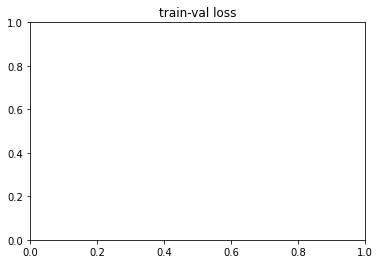

In [22]:
# train-validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('train-val loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('loss')
plt.xlabel('training epochs')
plt.legend()
plt.show()

NameError: name 'metric_hist' is not defined

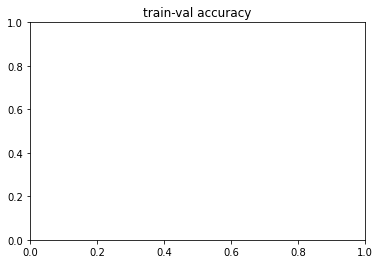

In [23]:
# plot accuracy progress
plt.title('train-val accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('accuracy')
plt.xlabel('training epochs')
plt.legend()
plt.show()